In [1]:
%load_ext pyinstrument

In [ ]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
importlib.reload(kgs)
import pack_cuda
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()

local
local


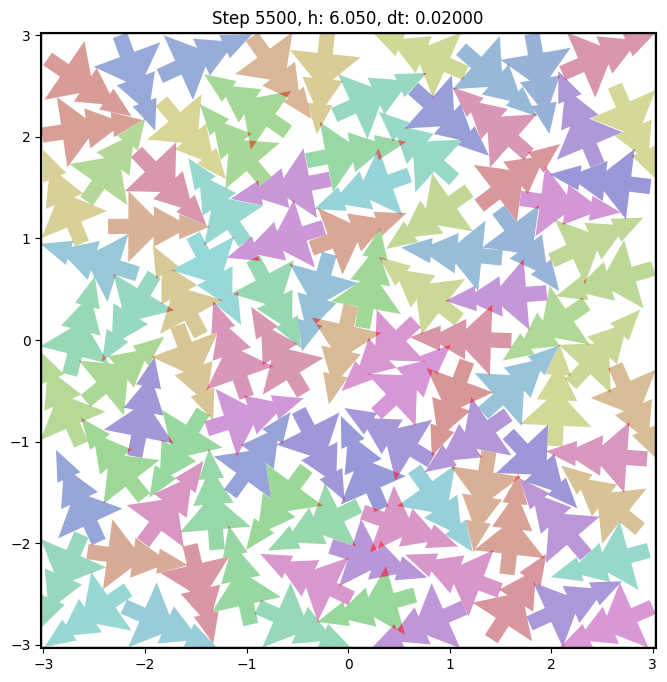

In [ ]:
import pack_basics
import pack_vis
import pack_cost
import numpy as np
import cupy as cp
importlib.reload(pack_basics)
importlib.reload(pack_vis)
N=100
tree_list = pack_basics.place_random(N, np.sqrt(N)/2, generator=np.random.default_rng(seed=43))
#tree_list.xyt = [[0.,0.,0.],[0.,1.,np.pi]]
#pack_vis.visualize_tree_list(tree_list)


from matplotlib import animation
from IPython.display import HTML, display, clear_output
cost = pack_cost.CostCompound(costs=[pack_cost.AreaCost(scaling=0.), pack_cost.BoundaryDistanceCost(scaling=5.), pack_cost.CollisionCostOverlappingArea()])

N_steps = 100000
dt = 0.02
xyt_list = cp.zeros((N_steps, tree_list.N, 3))
xyt = cp.array(tree_list.xyt)
cost.compute_cost(cp.array(tree_list.xyt[None]), cp.array([[1.]]));

#%pyinstrument total_cost, total_grad = cost.compute_total_cost(cp.array(tree_list.xyt), include_gradients=True)

plt.ion()  # Enable interactive mode
fig, ax = plt.subplots(figsize=(8, 8))
h=cp.array([np.sqrt(N)/2])
prev_cost = cp.inf
i_step = 0
while True:
    xyt_list[i_step] = xyt
    total_cost, total_grad, bound_grad = cost.compute_cost(xyt[None], h[None])
    # if total_cost > prev_cost and dt>1e-3:
    #     #print(i_step, prev_cost, total_cost, dt)
    #     dt *= 0.5
    # else:
    #     dt *= 1.01
    prev_cost = total_cost
    xyt -= dt * total_grad[0]
    h -= dt * bound_grad[0]

    if i_step==1500:
        cost.costs[0].scaling=0.3
        #dt = 0.001

    if i_step==3000:
        cost.costs[0].scaling=0.1

    if i_step==5000:
        cost.costs[0].scaling=0.03

    if i_step==6000:
        cost.costs[0].scaling=0.01

    if i_step==7000:
        cost.costs[0].scaling=0.003
    
    if i_step==10000:
        cost.costs[0].scaling=0.001
        #dt/=3

    if i_step==12000:        
        cost.costs[0].scaling=0.
        dt =  0.02
        #dt/=3

    if i_step==16000:        
        i_step = 1499
        #dt/=3

    # if i_step==1500:
    #     cost.costs[0].scaling=0.001
    #     dt = 0.001   
    
    if (i_step)%100==0:
        #print(i_step)
        ax.clear()
        ax.set_aspect('equal', adjustable='box')
        tree_list.xyt = xyt
        pack_vis.visualize_tree_list(tree_list, ax=ax, h=h[0])
        ax.set_title(f'Step {i_step}, h: {float(h[0]):.3f}, dt: {dt:.5f}')
        display(fig)
        clear_output(wait=True)

    i_step += 1
        
plt.ioff()  # Disable interactive mode
print(f"Final x position: {xyt[0,0]}")


In [ ]:
6.520
6.471
6.75**2/100 * 200

91.125

In [ ]:
tree_list.xyt = cp.asnumpy(xyt)
pack_vis.visualize_tree_list(tree_list)
h**2/tree_list.N

array([0.45274563])

In [ ]:
# importlib.reload(pack_vis)

# # compute fixed axis limits from the last frame (convert from cupy to numpy)
# last = cp.asnumpy(xyt_list[-1])
# minx, maxx = last[:, 0].min(), last[:, 0].max()
# miny, maxy = last[:, 1].min(), last[:, 1].max()
# dx, dy = maxx - minx, maxy - miny
# pad = 0.1 * max(dx, dy, 1e-3)  # small epsilon to avoid zero padding
# xlim = (minx - pad, maxx + pad)
# ylim = (miny - pad, maxy + pad)

# fig, ax = plt.subplots(figsize=(10, 10))

# def animate(i):
#     ax.clear()
#     ax.set_xlim(*xlim)
#     ax.set_ylim(*ylim)
#     ax.set_aspect('equal', adjustable='box')
#     tree_list.xyt = xyt_list[i]
#     pack_vis.visualize_tree_list(tree_list, ax=ax)
#     ax.set_xlim(*xlim)
#     ax.set_ylim(*ylim)
#     ax.set_title(f'Step {i}/{N_steps-1}')

# anim = animation.FuncAnimation(fig, animate, frames=np.round(np.linspace(0, N_steps-1, 100)).astype(int), interval=100)
# plt.close()
# HTML(anim.to_jshtml())